In [21]:
# imports

import pandas as pd

In [ ]:
# load data from metabolic panel csv

df = pd.read_csv('LSDS-8_Comprehensive_Metabolic_Panel_CMP_TRANSFORMED_all_astronauts.csv')

In [ ]:
# check for missing values

missing = df.isnull().sum()
missing = missing[missing > 0]
missing

total_bilirubin_value_milligram_per_deciliter                                        1
bun_to_creatinine_ratio_value                                                       22
bun_to_creatinine_ratio_range_min                                                    1
bun_to_creatinine_ratio_range_max                                                    1
egfr_african_american_range_max_milliliter_per_minute_per_1.73_meter_squared        28
egfr_non_african_american_range_max_milliliter_per_minute_per_1.73_meter_squared    28
dtype: int64

## Treating Missing Values by Imputing or dropping

In [ ]:
# bilirubin values can be skewed, so median is more robust than mean

df["total_bilirubin_value_milligram_per_deciliter"] = (
    df["total_bilirubin_value_milligram_per_deciliter"].fillna(
        df["total_bilirubin_value_milligram_per_deciliter"].median()
    )
)

In [5]:
# do we drop this ? 22/28 are missing
df["bun_to_creatinine_ratio_value"] = (
    df["bun_to_creatinine_ratio_value"]
    .fillna(df["bun_to_creatinine_ratio_value"].median())
)

# values can be skewed, so median is more robust than mean

df["bun_to_creatinine_ratio_range_min"] = (
    df["bun_to_creatinine_ratio_range_min"]
    .fillna(df["bun_to_creatinine_ratio_range_min"].median())
)

# bilirubin values can be skewed, so median is more robust than mean

df["bun_to_creatinine_ratio_range_max"] = (
    df["bun_to_creatinine_ratio_range_max"]
    .fillna(df["bun_to_creatinine_ratio_range_max"].median())
)

In [7]:
# drop empty columns 

df = df.drop(
    columns=[
        "egfr_african_american_range_max_milliliter_per_minute_per_1.73_meter_squared",
        "egfr_non_african_american_range_max_milliliter_per_minute_per_1.73_meter_squared",
    ],
    errors="ignore",  # just in case column missing
)

In [ ]:
# check for missing values

missing = df.isnull().sum()
missing = missing[missing > 0]
missing

Series([], dtype: int64)

In [ ]:
# save cleaned data

df.to_csv('all_astronauts_filled.csv', index=False)   

In [23]:
#  new feature for anion gap

df["anion_gap"] = (
        df["sodium_value_millimol_per_liter"]
        - (df["chloride_value_millimol_per_liter"] + df["carbon_dioxide_value_millimol_per_liter"])
)

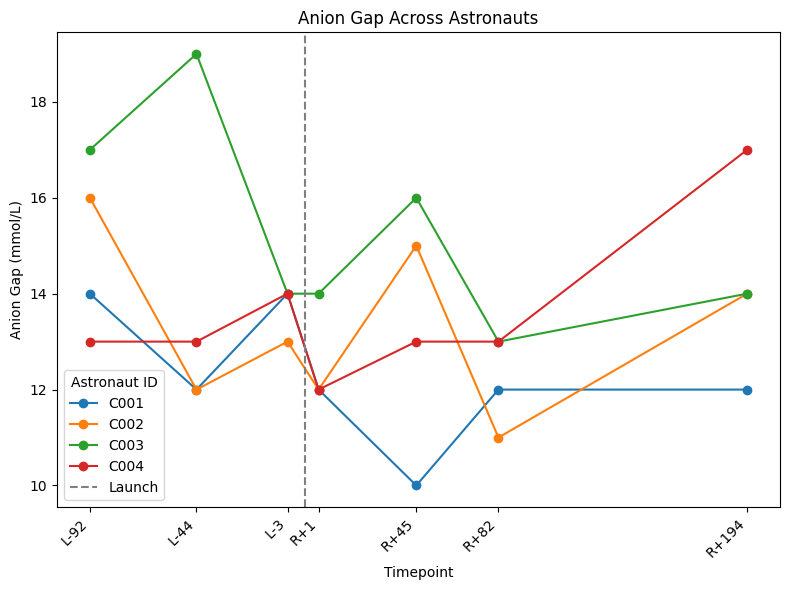

In [25]:
import matplotlib.pyplot as plt

# Map timepoints to numeric values
timepoint_mapping = {
    "L-92": -97,
    "L-44": -49,
    "L-3": -8,
    "R+1": 6,
    "R+45": 50,
    "R+82": 87,
    "R+194": 199
}

df["day"] = df["timepoint"].map(timepoint_mapping)

# -------------------------------
#  Anion Gap plot
# -------------------------------
df_anion = df[
    ["astronautID", "day", "timepoint", "anion_gap"]
].dropna()
df_anion = df_anion.sort_values(by=["astronautID", "day"])

plt.figure(figsize=(8,6))
for astro_id, sub_df in df_anion.groupby("astronautID"):
    plt.plot(
        sub_df["day"],
        sub_df["anion_gap"],
        marker="o",
        label=astro_id
    )

plt.title("Anion Gap Across Astronauts")
plt.xlabel("Timepoint")
plt.ylabel("Anion Gap (mmol/L)")
plt.axvline(0, color="gray", linestyle="--", label="Launch")
plt.xticks(
    ticks=list(timepoint_mapping.values()),
    labels=list(timepoint_mapping.keys()),
    rotation=45,
    ha="right"
)
plt.legend(title="Astronaut ID")
plt.tight_layout()
plt.show()
